In [1]:
import matplotlib
import numpy as np
from numpy import log10, exp, log
import matplotlib.pyplot as plt
import healpy as hp
from scipy import stats
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
import ephem
from scipy.integrate import quad
from astropy.time import Time
from scipy.interpolate import interp1d
from astropy.io import fits
from scipy.optimize import curve_fit
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
import astropy.cosmology as CS

In [2]:
F_21=1420.405 #MHz
def f2z(f):
    #freq in MHz
    return F_21/f-1.

#Cosmology needs to be coherent with the Pinocchio simulation
C = 2.99e8 # SPEED OF LIGHT IN M/S
h=0.73
Omegab=0.045
Omegam=0.25
COSMO = CS.FlatLambdaCDM(H0=h*100, Om0=Omegam,Ob0=Omegab)  # Using H0 = 100 km/s/Mpc

In [3]:
outname='TEST2'

In [4]:
indir='/home/spinelli/Documents/HIP-POP/output/%s/' % outname

In [5]:
indir

'/home/spinelli/Documents/HIP-POP/output/TEST2/'

In [6]:
nside=256
f_vec = np.loadtxt(indir+outname+"_frequencies.txt")
Nf = len(f_vec)
fmin=f_vec[0]
fmax=f_vec[-1]
print(Nf, fmin,fmax)

10 1100.0 1110.0


In [29]:
#choose a frequency number
ff=0
filename=indir+'maps_'+str(nside)+'_'+str(ff)+'_of'+str(Nf)+'_'+outname+'.npz'
#read the various maps
mapNh=np.load(filename)['mapNh'] #halo counts
mapMh=np.load(filename)['mapMh'] #halo mass
mapHI=np.load(filename)['mapHI'] #HI 
mapTb=np.load(filename)['mapTb'] #temperature brightness

/tmp/ipykernel_2955505/1439414028.py:1: RuntimeWarning: divide by zero encountered in log10
  hp.mollview(log10(mapMh)+10, title='Halo mass map at redshift %1.3f ' % f2z(f_vec[ff]), min=10.9, max=13, unit='M0/h',cmap=cm.magma)


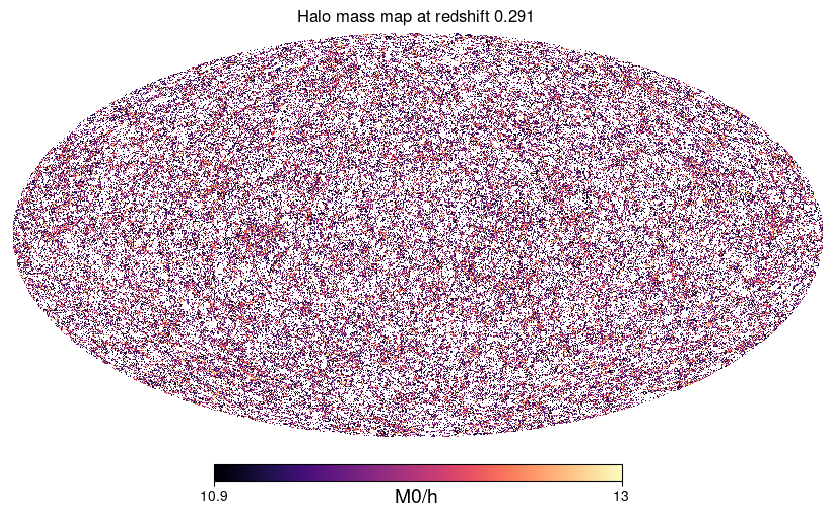

In [30]:
hp.mollview(log10(mapMh)+10, title='Halo mass map at redshift %1.3f ' % f2z(f_vec[ff]), min=10.9, max=13, unit='M0/h',cmap=cm.magma)
plt.show()
plt.close()

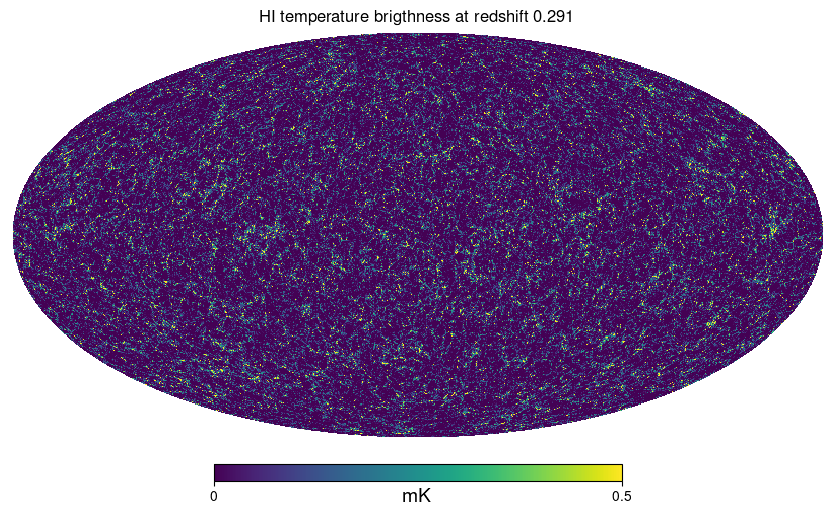

In [31]:
hp.mollview(mapTb, title='HI temperature brigthness at redshift %1.3f' % f2z(f_vec[ff]), min=0,max=0.5, unit='mK')
plt.show()
plt.close()

In [10]:
#read the full data-cube
map_cube=np.zeros((Nf,hp.nside2npix(nside)))
for ff in range(Nf):
    filename=indir+'maps_'+str(nside)+'_'+str(ff)+'_of'+str(Nf)+'_'+outname+'.npz'
    #read the various maps
    map_cube[ff,:]=np.load(filename)['mapTb'] #temperature brightness

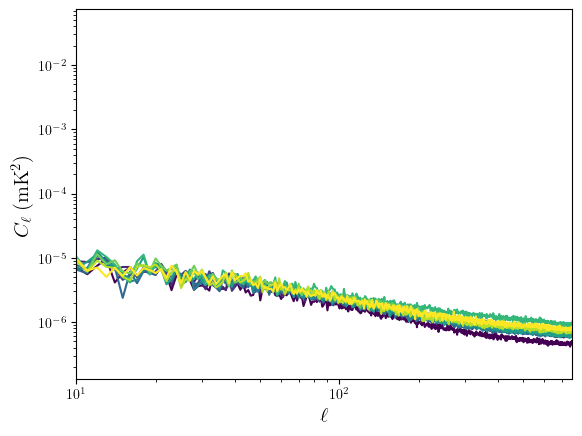

In [27]:
#plot the angular power spectrum for the full data-cube
lmax=3*nside
map_cube_cl=np.zeros((Nf,lmax+1))
colors = [cm.viridis(x) for x in np.linspace(0,1.,Nf)]

for ff in range(Nf):
    map_cube_cl[ff,:]=hp.anafast(map_cube[ff,:],lmax=lmax)
    plt.plot(np.arange(lmax+1),map_cube_cl[ff,:],linestyle='-', color=colors[ff])

plt.yscale('log')
plt.xscale('log')
plt.xlim(10,3*nside)
plt.xlabel(r"$\ell$", fontsize=15)
plt.ylabel(r"$C_\ell \;({\rm mK}^2)$", fontsize=15)
plt.show()
plt.close()

In [12]:
#let's focus on a MeerKLASS like patch

In [13]:
def footprint(ra_c,dec_c):
    #some realistic hardcoded values
    Ny=51
    Nx=151
    Delta=0.5
    ra = np.linspace(ra_c-((Nx-1)/2)*Delta,ra_c+((Nx-1)/2)*Delta,Nx)
    dec = np.linspace(dec_c-((Ny-1)/2)*Delta,dec_c+((Ny-1)/2)*Delta,Ny)
    ra_edges=np.zeros(Nx+1)
    dec_edges=np.zeros(Ny+1)
    ra_edges[1:]=ra+Delta
    ra_edges[0]=ra[0]-Delta
    dec_edges[1:]=dec+Delta
    dec_edges[0]=dec[0]-Delta
    return ra,dec,ra_edges,dec_edges

def cut_patch_flat(nside,map_in,ra_M,dec_M):
    #note it needs pixel EDGES
    npix=hp.nside2npix(nside)
    ipix=np.arange(npix)
    theta, phi=hp.pix2ang(nside,ipix)
    ra=phi
    dec=theta-np.pi/2.

    patch=np.zeros((len(ra_M)-1,len(dec_M)-1))
    for ir in range(len(ra_M)-1):
        for idd in range(len(dec_M)-1):
            pM=np.where((ra>ra_M[ir]/180*np.pi) & (ra<ra_M[ir+1]/180*np.pi) & (dec<dec_M[idd+1]/180*np.pi) & (dec>dec_M[idd]/180*np.pi))
            patch[ir,-idd-1]=np.mean(map_in[pM])
            
    return patch


def plot_patch(patch,label,title,cm=cm.viridis):

    fig, ax = plt.subplots()
    norm=plt.Normalize(vmin=np.min(patch), vmax=np.max(patch))
    extent=[np.min(ra),np.max(ra),np.min(dec),np.max(dec)]
    ax = plt.gca()
    im = ax.imshow(patch.T,extent=extent,norm=norm,origin='lower', cmap=cm, interpolation='nearest')
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax,label=label)


    ax.set_xlabel(r'${\rm R.A} (J2000) [^\circ]$',fontsize=15)
    ax.set_ylabel(r'${\rm Dec} (J2000) [^\circ]$',fontsize=15)
    fig.tight_layout()

In [14]:
#choose central ra and dec similar to MeerKLASS
ra,dec,ra_edges,dec_edges= footprint(160,-10)

In [15]:
#uncomment if you do want to save this info to file
#np.savez('footprint.npz',ra=ra,dec=dec,ra_edges=ra_edges,dec_edges=dec_edges)

In [16]:
#read the full HI data-cube
HI_cube=np.zeros((Nf,hp.nside2npix(nside)))
for ff in range(Nf):
    filename=indir+'maps_'+str(nside)+'_'+str(ff)+'_of'+str(Nf)+'_'+outname+'.npz'
    #read the various maps
    HI_cube[ff,:]=np.load(filename)['mapHI'] #HI content

patch_HI_cube = np.array([cut_patch_flat(nside,HI_cube[ff,:],ra_edges,dec_edges) for ff in range(Nf)])

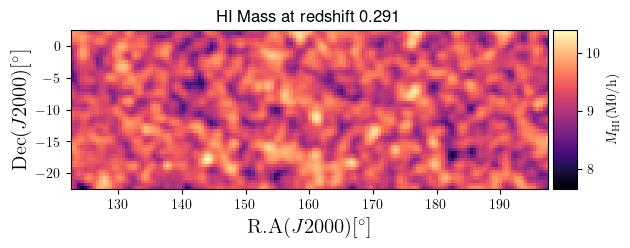

In [22]:
title='HI Mass at redshift %1.3f' % f2z(f_vec[ff])
ff=0
label=r'$M_{\rm HI} (\rm{M0/h})$'
plot_patch(log10(gaussian_filter(patch_HI_cube[ff,:], sigma=1))+10,label,title,cm=cm.magma)
plt.show()
plt.close()

In [18]:
patch_Tb_cube = np.array([cut_patch_flat(nside,map_cube[ff,:],ra_edges,dec_edges) for ff in range(Nf)])

In [19]:
patch_Tb_cube.shape

(10, 151, 51)

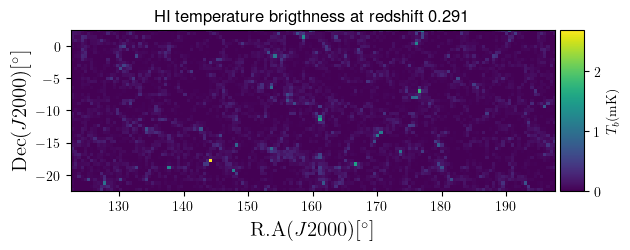

In [23]:
title='HI temperature brigthness at redshift %1.3f' % f2z(f_vec[ff])
ff=0
label=r'$T_b (\rm{mK})$'
plot_patch(patch_Tb_cube[ff,:],label,title)
plt.show()
plt.close()

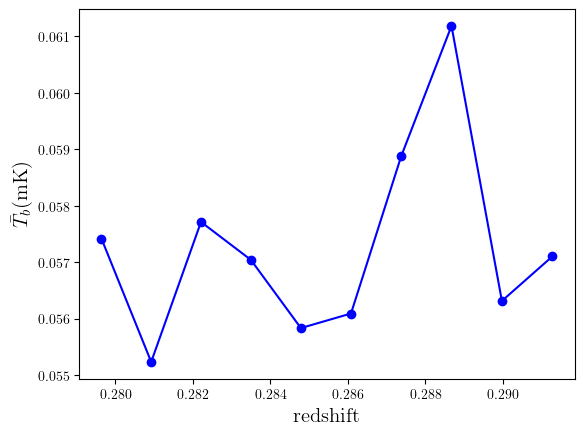

In [21]:
Nx = patch_Tb_cube.shape[1]
Ny = patch_Tb_cube.shape[2]
plt.plot(f2z(f_vec), np.mean(patch_Tb_cube.reshape(Nf,Nx*Ny),axis=1),color='b',marker='o')
plt.ylabel(r'$\bar{T}_b (\rm{mK})$',fontsize=15)
plt.xlabel(r'$\rm{redshift}$',fontsize=15)
plt.show()
plt.close()